<a href="https://colab.research.google.com/github/SimranAnand1/design_algo/blob/main/Simple_Integer_Linear_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pulp
from pulp import *
import numpy as np

     |████████████████████████████████| 14.2 MB 5.2 MB/s 


In [3]:
#a handful of sites
sites = ['org','A','B','C','D','E','F','G','H','I','J','K']
#non symetric distances
distances = dict( ((a,b),np.random.randint(10,50)) for a in sites for b in sites if a!=b )

In [4]:
#create the problme
prob=LpProblem("salesman",LpMinimize)
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost
#constraints
for k in sites:
    #every site has exactly one inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==1
    #every site has exactly one outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==1

In [5]:
#we need to keep track of the order in the tour to eliminate the possibility of subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)
#subtour elimination
N=len(sites)
for i in sites:
    for j in sites:
        if i != j and (i != 'org' and j!= 'org') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1
%time prob.solve()
print(LpStatus[prob.status])

CPU times: user 8.28 ms, sys: 5.73 ms, total: 14 ms
Wall time: 405 ms
Optimal


In [6]:
sites_left = sites.copy()
org = 'org'
tour=[]
tour.append(sites_left.pop( sites_left.index(org)))

while len(sites_left) > 0:
    
    for k in sites_left:
        if x[(org,k)].varValue ==1:
            tour.append( sites_left.pop( sites_left.index(k)))
            org=k
            break
            
tour.append('org')

tour_legs = [distances[(tour[i-1], tour[i])] for i in range(1,len(tour))]

print('Found optimal tour!')
print(' -> '.join(tour))

Found optimal tour!
org -> J -> H -> A -> K -> C -> G -> D -> F -> B -> I -> E -> org


In [7]:
sum(tour_legs)

200

In [8]:
from pulp import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [9]:
#a handful of sites
sites = ['org','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
print(len(sites)-1)

16


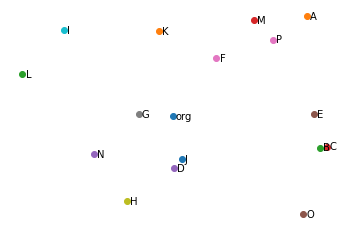

In [10]:
#make some positions (so we can plot this)
positions = dict( ( a, (np.random.rand()-.5, np.random.rand()-.5)) for a in sites)

positions['org']=(0,0)
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.gca().axis('off');

In [11]:
#straight line distance for simplicity
d = lambda p1,p2: np.sqrt( (p1[0]-p2[0])**2+ (p1[1]-p2[1])**2)

#calculate all the pairs
distances=dict( ((s1,s2), d(positions[s1],positions[s2])) for s1 in positions for s2 in positions if s1!=s2)

In [12]:
K = 4 #the number of sales people 
#create the problme
prob=LpProblem("vehicle",LpMinimize)
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost
#constraints
for k in sites:
    cap = 1 if k != 'org' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'org' and j!= 'org') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

In [13]:
%time prob.solve()
#prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])

CPU times: user 97.6 ms, sys: 17.5 ms, total: 115 ms
Wall time: 15.2 s
Optimal


In [14]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges
tours = get_next_site('org')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='org':
        t.append(get_next_site(t[-1][1])[-1])

In [15]:
for t in tours:
    print(' -> '.join([ a for a,b in t]+['org']))

org -> E -> C -> B -> O -> org
org -> F -> M -> A -> P -> org
org -> K -> I -> L -> G -> org
org -> N -> H -> D -> J -> org


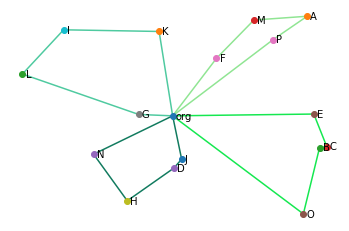

In [16]:
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.gca().axis('off');

In [17]:
print(value(prob.objective))

5.506965522535467
